In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

!pip install shap
import shap
shap.initjs()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 5.9 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive .mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Dataset/Employee.csv')

In [ ]:
data.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [ ]:
allData = pd.DataFrame(data)
allData.shape[1]

35

Text(0.5, 0, 'Age')

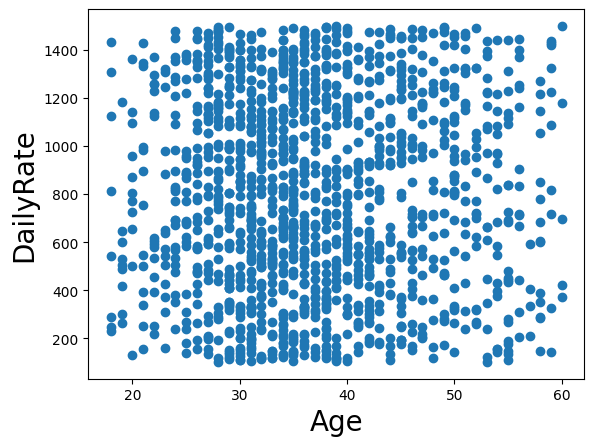

In [ ]:
plt.scatter(data['Age'],data['DailyRate'])
plt.ylabel('DailyRate',size=20)
plt.xlabel('Age',size=20)

Text(0.5, 0, 'Gender')

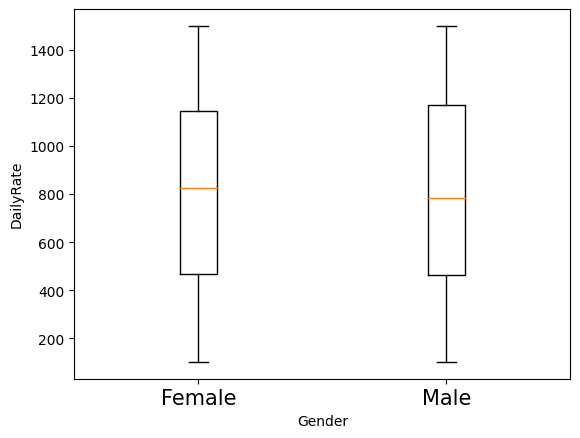

In [ ]:
plt.boxplot(data[data.Gender=='Female']['DailyRate'],positions=[1])
plt.boxplot(data[data.Gender=='Male']['DailyRate'],positions=[2])

plt.xticks(ticks=[1,2], labels=['Female','Male'],size=15)
plt.ylabel('DailyRate')
plt.xlabel('Gender')

In [ ]:
data.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


<Axes: >

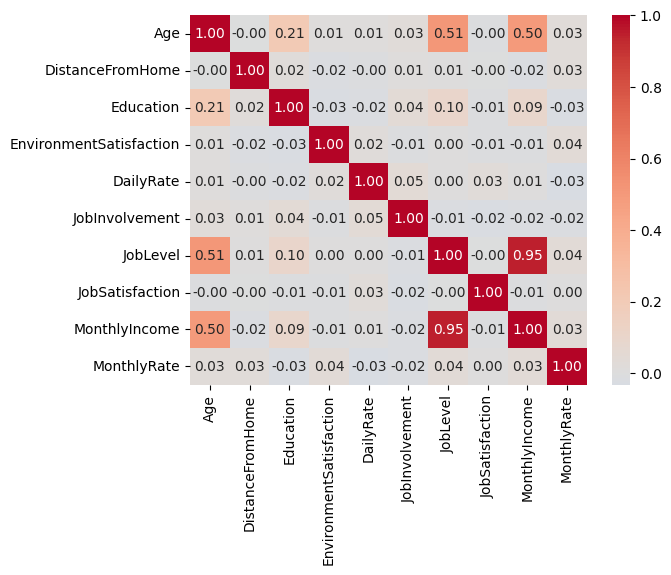

In [ ]:
#correlation heatmap
cont=['Age','DistanceFromHome','Education','EnvironmentSatisfaction',
      'Gender','DailyRate','JobInvolvement','JobLevel','JobSatisfaction','MonthlyIncome',
      'MonthlyRate']
corr_matrix=pd.DataFrame(data[cont],columns=cont).corr()
sns.heatmap(corr_matrix,
            cmap='coolwarm',
            center=0,
            annot=True,
            fmt='.2f'
            )

In [ ]:
#Feature Engineering
y=data['DailyRate']
x = data[['Gender','Education', 'EnvironmentSatisfaction', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate']]

In [ ]:
categorical_columns_name = allData.select_dtypes(include=['object']).columns

print("Categorical columns:", categorical_columns_name)

Categorical columns: Index(['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender',
       'JobRole', 'MaritalStatus', 'Over18', 'OverTime'],
      dtype='object')


In [ ]:
X=pd.DataFrame(data.iloc[:, data.columns != 'Attrition'])
# X = X.drop("BusinessTravel", axis=1)
Y = pd.DataFrame(data['Attrition'])

In [ ]:
X

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,...,1,80,0,8,0,1,6,4,0,5
1,49,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,...,4,80,1,10,3,3,10,7,1,7
2,37,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,...,2,80,0,7,3,3,0,0,0,0
3,33,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,...,3,80,0,8,3,3,8,7,3,0
4,27,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,...,4,80,1,6,3,3,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,Travel_Frequently,884,Research & Development,23,2,Medical,1,2061,3,...,3,80,1,17,3,3,5,2,0,3
1466,39,Travel_Rarely,613,Research & Development,6,1,Medical,1,2062,4,...,1,80,1,9,5,3,7,7,1,7
1467,27,Travel_Rarely,155,Research & Development,4,3,Life Sciences,1,2064,2,...,2,80,1,6,0,3,6,2,0,3
1468,49,Travel_Frequently,1023,Sales,2,3,Medical,1,2065,4,...,4,80,0,17,3,2,9,6,0,8


In [ ]:
# Column names you want to find the indices for
column_names = ['BusinessTravel', 'Department', 'EducationField', 'Gender',
                'JobRole', 'MaritalStatus', 'Over18', 'OverTime']

# Find the column indices
column_indices = [X.columns.get_loc(col) for col in column_names]

# Print the results
for col, index in zip(column_names, column_indices):
    print(f"The column index of '{col}' is: {index}")

The column index of 'BusinessTravel' is: 1
The column index of 'Department' is: 3
The column index of 'EducationField' is: 6
The column index of 'Gender' is: 10
The column index of 'JobRole' is: 14
The column index of 'MaritalStatus' is: 16
The column index of 'Over18' is: 20
The column index of 'OverTime' is: 21


In [ ]:
# Find the column indices
column_indices = [X.columns.get_loc(col) for col in column_names]

In [ ]:
# Print the results
for col, index in zip(column_names, column_indices):
    print(f"The column index of '{col}' is: {index}")

The column index of 'BusinessTravel' is: 1
The column index of 'Department' is: 3
The column index of 'EducationField' is: 6
The column index of 'Gender' is: 10
The column index of 'JobRole' is: 14
The column index of 'MaritalStatus' is: 16
The column index of 'Over18' is: 20
The column index of 'OverTime' is: 21


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

from sklearn.feature_selection import chi2
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from sklearn.metrics import (precision_score, recall_score,f1_score, accuracy_score,mean_squared_error,mean_absolute_error)
from sklearn import metrics
import pickle
from sklearn.preprocessing import Normalizer
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import StackingClassifier
from matplotlib import pyplot

In [ ]:
#Apply Encodeing Technique
from sklearn.preprocessing import OneHotEncoder
ohe=OneHotEncoder(drop='first',sparse=False)

In [ ]:
from sklearn.compose import ColumnTransformer
transformer=ColumnTransformer(transformers=[('tkl',OneHotEncoder(drop='first'),[1,3,6,10,14,16,20,21])] ,remainder='passthrough')

In [ ]:
x_transform = transformer.fit_transform(X)

In [ ]:
x_transform

array([[0., 1., 0., ..., 4., 0., 5.],
       [1., 0., 1., ..., 7., 1., 7.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 1., ..., 2., 0., 3.],
       [1., 0., 0., ..., 6., 0., 8.],
       [0., 1., 1., ..., 3., 1., 2.]])

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder=LabelEncoder()

In [ ]:
Y.Attrition = label_encoder.fit_transform(Y.Attrition)

In [ ]:
y_transform = Y
y_transform

,Attrition
0,1
1,0
2,1
3,0
4,0
...,...
1465,0
1466,0
1467,0
1468,0


In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
scaler = sc.fit(x_transform)
X_data = scaler.transform(x_transform)

In [ ]:
# Apply SMOTE
#borderline SMOTE
#ad
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_resampled, Y_resampled = smote.fit_resample(x_transform, y_transform)

In [ ]:
from sklearn.model_selection import train_test_split

x_traindata, x_testdata, y_traindata, y_testdata = train_test_split(X_resampled, Y_resampled, test_size=0.2, random_state=42)
#x_traindata,x_testdata,y_traindata,y_testdata=train_test_split(X_data,Y,test_size=0.2,random_state=123)

print(x_traindata.shape, x_testdata.shape, y_traindata.shape, y_testdata.shape)

(1972, 47) (494, 47) (1972, 1) (494, 1)


In [ ]:
y_traindata

,Attrition
463,1
1037,0
1114,0
1503,1
1818,1
...,...
1638,1
1095,0
1130,0
1294,0


In [ ]:
x['Gender.Male'] = [1 if s == 'Male' else 0 for s in x['Gender']]
x['Gender.Female'] = [1 if s == 'Female' else 0 for s in x['Gender']]
x=x.drop('Gender',axis=1)
x.head()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Education,EnvironmentSatisfaction,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,Gender.Male,Gender.Female
0,2,2,2,4,5993,19479,0,1
1,1,3,2,2,5130,24907,1,0
2,2,4,1,3,2090,2396,1,0
3,4,4,1,3,2909,23159,0,1
4,1,1,1,2,3468,16632,1,0


In [ ]:
model=xgb.XGBRegressor(objective='reg:squarederror')
model.fit(x,y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Text(0.5, 0, 'Actual')

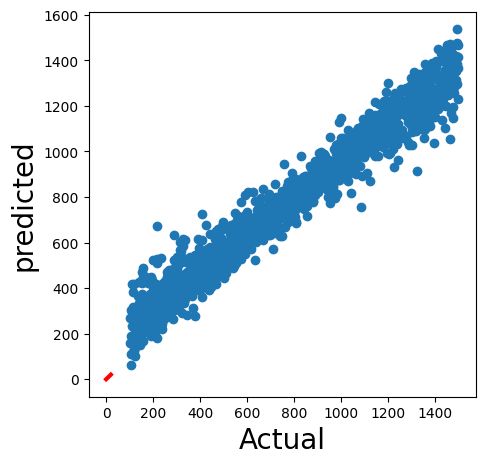

In [ ]:
#Get predictions
y_pred=model.predict(x)

#model Evaluation
plt.figure(figsize=(5,5))
plt.scatter(y,y_pred)
plt.plot([0, 20],
         [0, 20 ],
         color='red',
         linestyle='-',
         linewidth=3
         )
plt.ylabel('predicted',size=20)
plt.xlabel('Actual',size=20)

In [ ]:
#SHAP Values
explainer=shap.Explainer(model)
shap_values=explainer(x)


[07:46:58] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


In [ ]:
np.shape(shap_values.values)

(1470, 8)

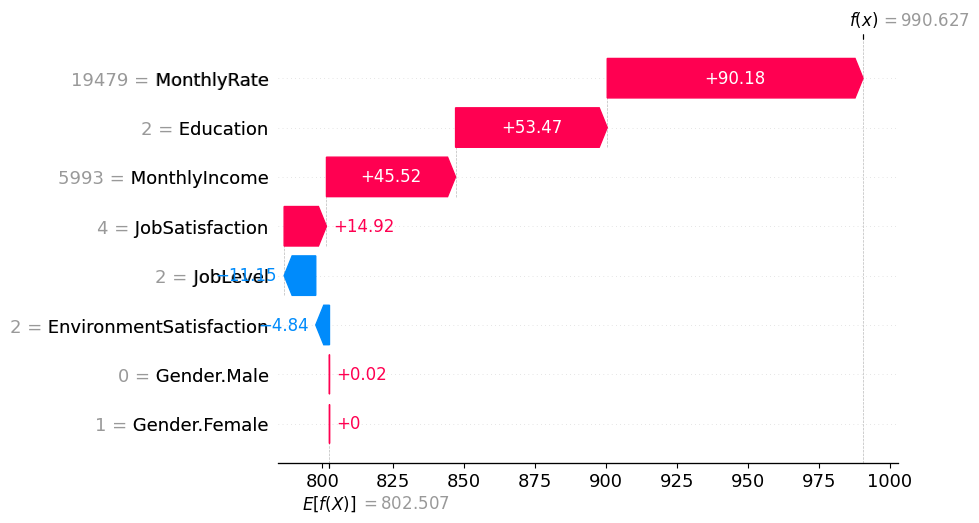

In [ ]:
#waterfall plot for first observation
shap.plots.waterfall(shap_values[0])

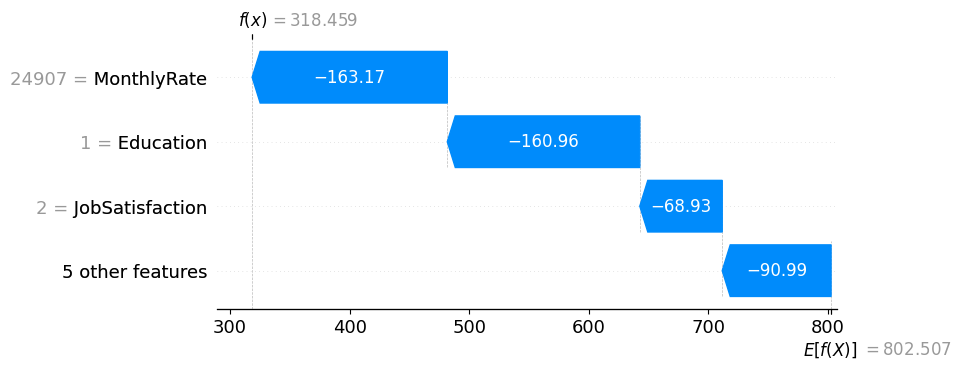

In [ ]:
shap.plots.waterfall(shap_values[1],max_display=4)

In [ ]:
!pip install shap
import shap
shap.initjs()

In [ ]:
# background = x_traindata
# explainer = shap.DeepExplainer(model, background)

# data_for_prediction = X_test[1:2]
# print( "Data for prediction: {}".format(data_for_prediction) )

# shap_values = explainer.shap_values(data_for_prediction)
# shap.force_plot(explainer.expected_value[0], shap_values[0], data_for_prediction)

In [ ]:
#force plot
shap.plots.force(shap_values[0])

In [ ]:
#Stacked force plot
shap.plots.force(shap_values[0:100])

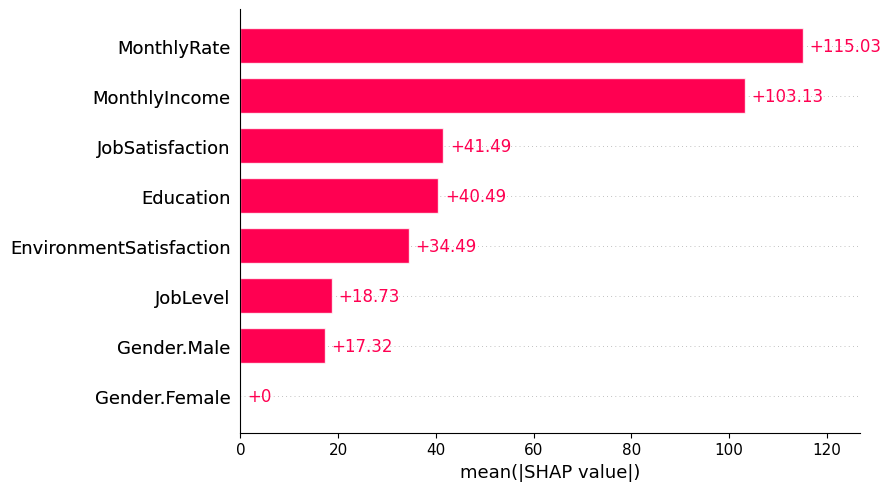

In [ ]:
#Absulate mean shap
shap.plots.bar(shap_values)

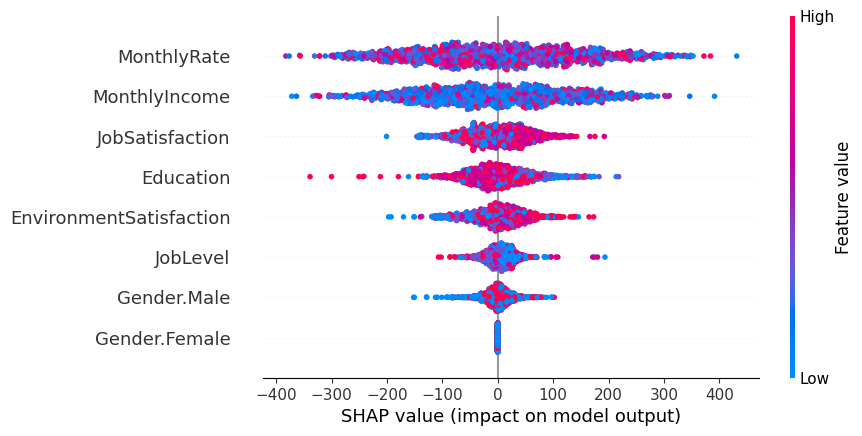

In [ ]:
#Beewarm plot
shap.plots.beeswarm(shap_values)

In [ ]:
!pip install slicer

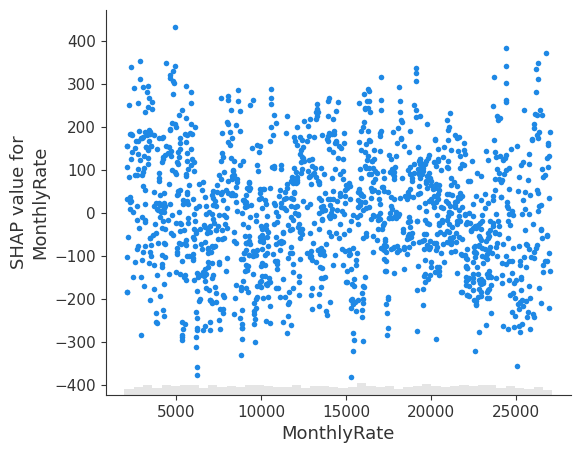

In [ ]:
#Dependence plot
shap.plots.scatter(shap_values[:,"MonthlyRate"])

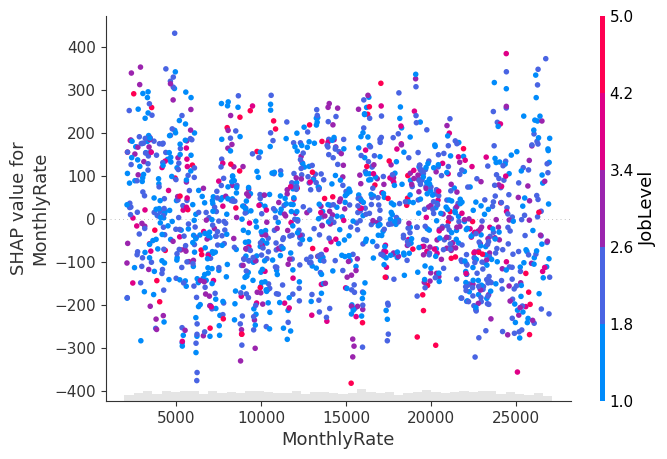

In [ ]:
shap.plots.scatter(shap_values[:,"MonthlyRate"],
                   color=shap_values[:,"JobLevel"])

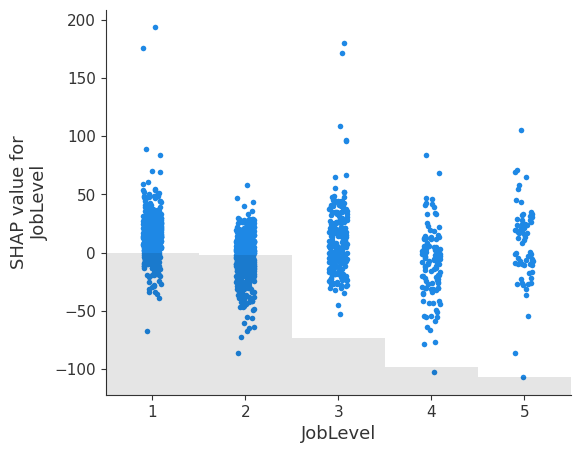

In [ ]:
shap.plots.scatter(shap_values[:,"JobLevel"])

In [ ]:
#Customer shap object
shap_values

.values =
array([[ 5.3466061e+01, -4.8397470e+00, -1.1149830e+01, ...,
         9.0184509e+01,  1.9554708e-02,  0.0000000e+00],
       [-1.6095752e+02, -3.9184711e+01, -1.3919143e+01, ...,
        -1.6316747e+02,  2.3079092e+01,  0.0000000e+00],
       [ 9.8527809e+01, -1.6254385e+01, -5.3116412e+00, ...,
         1.8016930e+02,  1.6600552e+01,  0.0000000e+00],
       ...,
       [-4.5464592e+01, -2.1486414e+01, -1.1238820e+01, ...,
        -7.1313713e+01,  8.2611799e+00,  0.0000000e+00],
       [-3.4242676e+01,  3.6059132e+01,  7.5674887e+00, ...,
         8.3993279e+01,  7.7406292e+00,  0.0000000e+00],
       [-2.7950502e+01, -2.4099848e+01,  1.4200169e+01, ...,
        -3.5318947e+01, -1.1374547e+00,  0.0000000e+00]], dtype=float32)

.base_values =
array([802.50684, 802.50684, 802.50684, ..., 802.50684, 802.50684,
       802.50684], dtype=float32)

.data =
array([[    2,     2,     2, ..., 19479,     0,     1],
       [    1,     3,     2, ..., 24907,     1,     0],
       [    2,  

In [ ]:
np.shape(shap_values.values)

(1470, 8)